# Neural Networks & Deep Learning HomeWork 02
This is the second homework of NNDL course  
By  
* Ali Ranjbari, 810198570
* AmirHossein Alizad, 810197000

## 2. Introduction to CNN networks

In [1]:
# !pip install torchmetrics

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cpu


### Load dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                                  download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                                  download=True, transform=transform)

Widget Javascript not detected.  It may not be installed or enabled properly.


AttributeError: 'FloatProgress' object has no attribute 'style'

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 16,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = 16,
                                           shuffle=True)

In [7]:
classes = train_dataset.classes

First see some examples of dataset

In [ ]:
def show_image(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()
def show_labels(labels):
  names = []
  for i in labels:
    names.append(classes[i.item()])
  return names

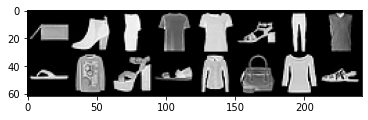

['Bag', 'Ankle boot', 'Dress', 'T-shirt/top', 'T-shirt/top', 'Sandal', 'Trouser', 'Pullover']
['Sandal', 'Pullover', 'Sandal', 'Sandal', 'Coat', 'Bag', 'T-shirt/top', 'Sandal']


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
show_image(torchvision.utils.make_grid(images))
labels_name = show_labels(labels)
top_half = labels_name[:8]
bottom_half = labels_name[8:]
print(top_half)
print(bottom_half)

### Make two different CNN architecture

First architecture is the **first** architecture that introduced in the **"CNN Model for Image Classification on MNIST and Fashion-MNIST Datast"** paper

In [8]:
class CNN1(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.2)
    

  def forward(self, x):
    x =  x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(self.fc2(x))
    return x


Second selected architecture is the **fifth** architecture from the paper

In [9]:
class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)    # input: 28*28 
    self.conv2 = nn.Conv2d(32, 32, 3)   # input: 26*26
    self.pool1 = nn.MaxPool2d(2, 2)     # input: 24*24
    self.dropout1 = nn.Dropout(0.25)
    self.conv3 = nn.Conv2d(32, 64, 3)   # input: 12*12
    self.conv4 = nn.Conv2d(64, 64, 3)   # input: 10*10
    self.pool2 = nn.MaxPool2d(2,2)      # input: 8*8
    self.dropout2 = nn.Dropout(0.25)
    self.fc1 = nn.Linear(64*4*4, 512)   # input: 4*4
    self.dropout3 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 10)
    

  def forward(self, x):
    
    # conv1
    x = F.relu(self.conv1(x))

    # conv2
    x = F.relu(self.conv2(x))
    x = self.dropout1(self.pool1(x))

    # conv3
    x = F.relu(self.conv3(x))

    # conv 4
    x = F.relu(self.conv4(x))
    x = self.dropout2(self.pool2(x))

    # fully connected layers
    x = x.view(-1, 64*4*4)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    

    return x



### Training 

First define a function `train` which will be use for training each model with desired parameters

In [12]:
def train(model, dataset, criterion, optimizer, num_epochs, batch_size, verbose=True) -> dict:
  
  data_loader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True)

  x = dataset.data.float()
  y = dataset.targets.int()
  x = x.to(device)
  y = y.to(device)

  results = {'accuracy':[], 'loss':[], 'precision':[], 'f1_score':[]}
  n_total_steps = len(data_loader)
  for epoch in range(num_epochs):
    if verbose:
      print(f"***** Epoch {epoch+1} of {num_epochs} *****")
      
    for i, (images, labels) in enumerate(data_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i % 10 == 0:
        print(f"[{i}/{n_total_steps}], loss: {loss.item():.4f}")
      
    
    # Compute accuracy, precision, F1
    preds = model(x)
    acc = torchmetrics.functional.accuracy(preds, y).item()
    prec = torchmetrics.functional.precision(preds, y).item()
    f1 = torchmetrics.functional.f1_score(preds, y).item()

    results['accuracy'].append(acc)
    results['loss'].append(loss)
    results['precision'].append(prec)
    results['f1_score'].append(f1)
    if verbose:
      print(f"Total Loss : {loss.item():.4f}")
      print(f"Accuracy   : {acc*100:.2f} %")
      print(f"Precision  : {prec*100:.2f} %")
      print(f"F1 score   : {f1*100:.2f} %\n")
  return results
    

#### 1. First architecture

In [ ]:
model1 = CNN1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.002)

results = train(
              model1,
              train_dataset,
              criterion,
              optimizer,
              num_epochs = 100,
              batch_size = 64,
              verbose=True)


***** Epoch 1 of 100 *****
Total Loss : 0.4684
Accuracy   : 73.51 %
Precision  : 73.51 %
F1 score   : 73.51 %

***** Epoch 2 of 100 *****
Total Loss : 0.6829
Accuracy   : 75.09 %
Precision  : 75.09 %
F1 score   : 75.09 %

***** Epoch 3 of 100 *****
Total Loss : 0.5246
Accuracy   : 77.00 %
Precision  : 77.00 %
F1 score   : 77.00 %

***** Epoch 4 of 100 *****
Total Loss : 0.6416
Accuracy   : 77.68 %
Precision  : 77.68 %
F1 score   : 77.68 %

***** Epoch 5 of 100 *****
Total Loss : 0.6037
Accuracy   : 76.10 %
Precision  : 76.10 %
F1 score   : 76.10 %

***** Epoch 6 of 100 *****
Total Loss : 0.7815
Accuracy   : 77.76 %
Precision  : 77.76 %
F1 score   : 77.77 %

***** Epoch 7 of 100 *****
Total Loss : 0.6369
Accuracy   : 77.50 %
Precision  : 77.50 %
F1 score   : 77.50 %

***** Epoch 8 of 100 *****
Total Loss : 0.3561
Accuracy   : 77.69 %
Precision  : 77.69 %
F1 score   : 77.69 %

***** Epoch 9 of 100 *****
Total Loss : 0.4978
Accuracy   : 77.92 %
Precision  : 77.92 %
F1 score   : 77.92 %

*

#### 2. Second architecture

In [13]:
model2 = CNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model2.parameters(), lr=0.002)

loss, accuracy = train(
                    model2,
                    train_dataset,
                    criterion,
                    optimizer,
                    num_epochs = 50,
                    batch_size = 128,
                    verbose=True)


***** Epoch 1 of 50 *****
[0/469], loss: 2.3009
[10/469], loss: 2.3382
[20/469], loss: 2.3029
[30/469], loss: 2.3100
[40/469], loss: 2.3011
[50/469], loss: 2.2760
[60/469], loss: 2.5132
[70/469], loss: 1.1512
[80/469], loss: 0.9910
[90/469], loss: 1.2055
[100/469], loss: 1.0796
[110/469], loss: 0.9631
[120/469], loss: 0.7359
[130/469], loss: 0.7387
[140/469], loss: 0.9946
[150/469], loss: 0.7720
[160/469], loss: 0.8050
[170/469], loss: 0.6765
[180/469], loss: 0.6059
[190/469], loss: 0.7072
[200/469], loss: 0.4809
[210/469], loss: 0.6181
[220/469], loss: 0.6013
[230/469], loss: 0.7521
[240/469], loss: 0.5999
[250/469], loss: 0.7096
[260/469], loss: 0.7116
[270/469], loss: 0.5997
[280/469], loss: 0.6255
[290/469], loss: 0.4675
[300/469], loss: 0.5951
[310/469], loss: 0.4860
[320/469], loss: 0.4664
[330/469], loss: 0.4975
[340/469], loss: 0.5326
[350/469], loss: 0.6091
[360/469], loss: 0.4187
[370/469], loss: 0.5117
[380/469], loss: 0.5843
[390/469], loss: 0.5872
[400/469], loss: 0.5227
[

RuntimeError: ignored

### Test 
First define the `test` function to test owr trained model

In [ ]:
def test(model, dataset, verbose=False):
  x = dataset.data.float().to(device)
  y = dataset.targets.int().to(device)

  preds = model(x)
  acc = torchmetrics.functional.accuracy(preds, y).item()
  prec = torchmetrics.functional.precision(preds, y).item()
  f1 = torchmetrics.functional.f1_score(preds, y).item()

  if verbose:
    print(f"Accuracy: {f1:.2f}, Precision: {prec:.2f}, F1 Score: {f1:.2f}")

  return acc, prec, f1

Testing first model

In [ ]:
test(model1, test_dataset, verbose=True)

Accuracy: 0.77, Precision: 0.77, F1 Score: 0.77


(0.7651000022888184, 0.7651000022888184, 0.7651000022888184)

In [ ]:
test(model2, test_dataset, verbose=True)

NameError: ignored